In [251]:
import pandas as pd
import numpy as np
import matplotlib
import sklearn
import torch

import preprocessing
import train

In [252]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [253]:
M_data_2019_04_08 = preprocessing.Preprocessing('M_data_2019_04_08','/Users/cm/20190408/','home-assistant_v2.db')

In [254]:
rooms = ['schlafzimmer','kuche','wohnzimmer']

In [255]:
M_data_2019_04_08.load_data(rooms=rooms)

(1527, 24)

#### Extract weather data

In [257]:
M_data_2019_04_08.extract_weather_data()

#### Build X Frames weather data

In [262]:
M_data_2019_04_08.build_x_frame(rooms=rooms)

#### Test with one specific DataFrame

In [263]:
frame = M_data_2019_04_08.get('train_climateschlafzimmer')

In [264]:
frame = frame.dropna(thresh=10)
frame = frame.dropna(axis=1)

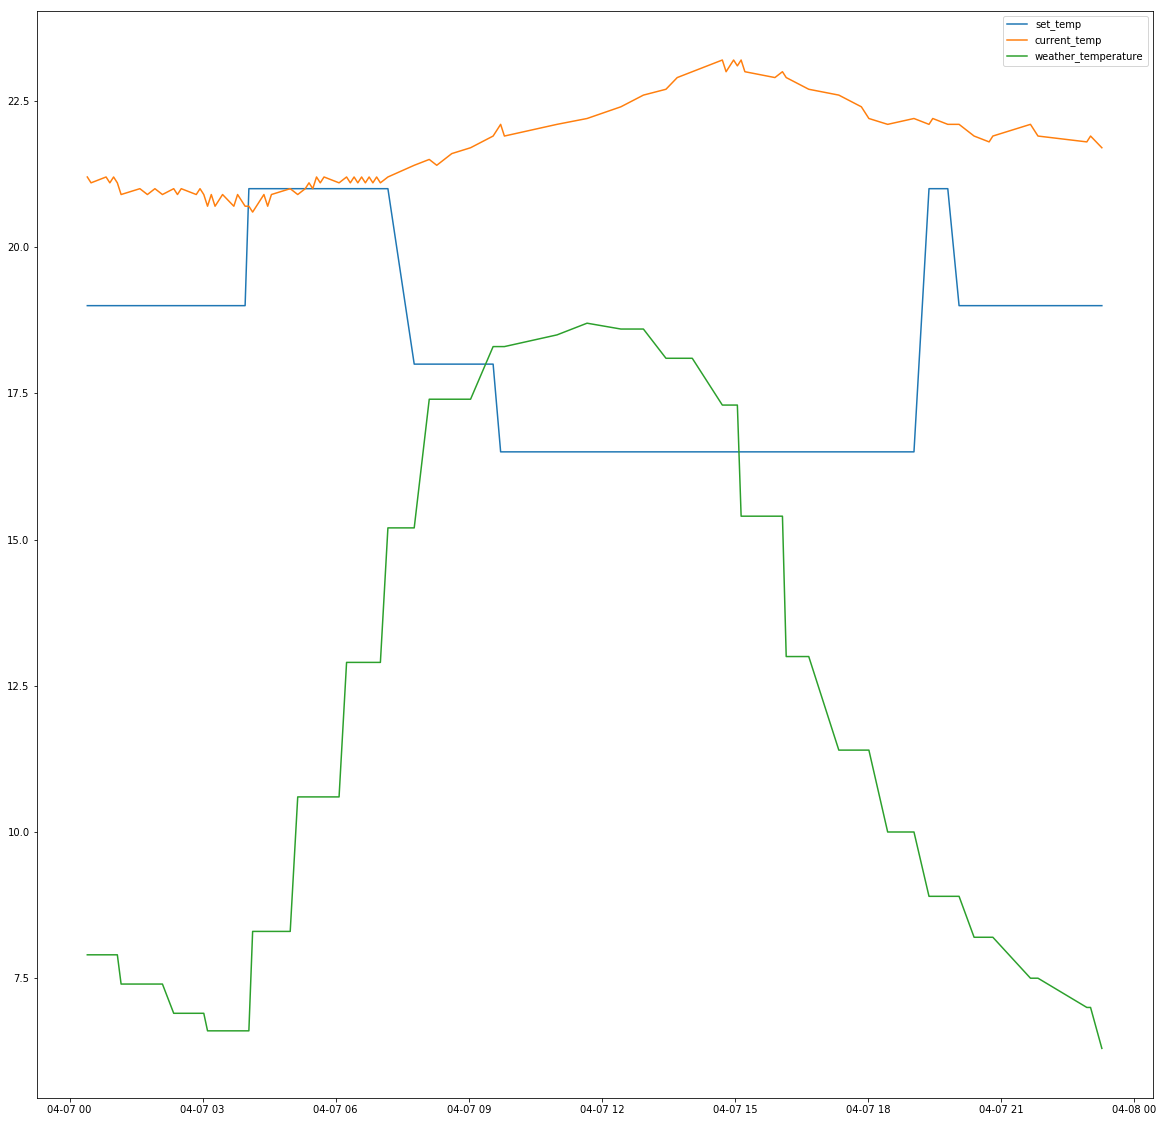

In [399]:
dates = matplotlib.dates.date2num(frame3['last_updated'])
fig1 = matplotlib.pyplot.figure(figsize=[20,20])
matplotlib.pyplot.plot_date(dates, frame3['set_temp'], '-')
matplotlib.pyplot.plot_date(dates, frame3['current_temp'], '-')
matplotlib.pyplot.plot_date(dates, frame3['weather_temperature'], '-')
#matplotlib.pyplot.plot_date(dates, frame3['wind_speed'], '-')
#matplotlib.pyplot.plot_date(dates, frame3['wind_direction'], '-')
#matplotlib.pyplot.plot_date(dates, frame3['humidity'], '-')
#matplotlib.pyplot.plot_date(dates, frame3['cloudiness'], '-')
#matplotlib.pyplot.plot_date(dates, frame3['pressure'], '-')
#matplotlib.pyplot.plot_date(dates, frame3['dewpoint_temperature'], '-')
matplotlib.pyplot.legend()

In [405]:
frame2 = pd.DataFrame(min_max_scaler.fit_transform(frame.drop('last_updated', axis=1).astype(np.float64)),columns=list(frame.drop('last_updated', axis=1).columns))

In [409]:
frame2.astype(np.float32).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1525 entries, 0 to 1524
Data columns (total 15 columns):
current_temp            1525 non-null float32
set_temp                1525 non-null float32
weather_temperature     1525 non-null float32
wind_speed              1525 non-null float32
pressure                1525 non-null float32
wind_direction          1525 non-null float32
humidity                1525 non-null float32
cloudiness              1525 non-null float32
low_clouds              1525 non-null float32
dewpoint_temperature    1525 non-null float32
day                     1525 non-null float32
month                   1525 non-null float32
year                    1525 non-null float32
time                    1525 non-null float32
weekday                 1525 non-null float32
dtypes: float32(15)
memory usage: 89.4 KB


In [269]:
train_set, val_set, test_set = train.train_val_test_split(frame, 0.2, 0.2)

In [355]:
X_train = train_set.drop(columns=['current_temp','last_updated'])
y_train = train_set['current_temp']
X_val = val_set.drop(columns=['current_temp','last_updated'])
y_val = val_set['current_temp']
X_test = test_set.drop(columns=['current_temp','last_updated'])
y_test = test_set['current_temp']

In [410]:
min_max_scaler = sklearn.preprocessing.MinMaxScaler()

In [411]:
min_max_scaler.fit(X_train.astype(np.float64))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [412]:
X_train = min_max_scaler.transform(X_train)
X_val= min_max_scaler.transform(X_val)

In [413]:
X_train.shape

(972, 14)

In [414]:
train_errors = []
test_errors = []
train_errors_val = []

for k in range(1,100):
    knn_iterated = sklearn.neighbors.KNeighborsRegressor(k)
    # Training
    knn_iterated.fit(X_train, y_train)
    
    # Predict
    y_k_predict = knn_iterated.predict(X_train)
    train_errors.append((1.0 * (y_train - y_k_predict)).mean())
                        
    y_k_predict_val = knn_iterated.predict(X_val)
    train_errors_val.append((1.0 * (y_val - y_k_predict_val)).mean())

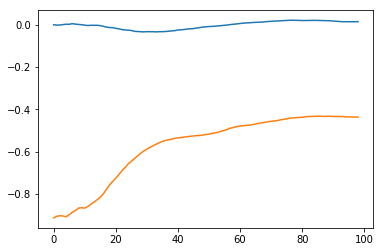

In [415]:
matplotlib.pyplot.plot(train_errors)
matplotlib.pyplot.plot(train_errors_val);

In [416]:
knn = KNeighborsRegressor(23)
knn.fit(X_train, y_train)
y_k_predict = knn.predict(X_train)

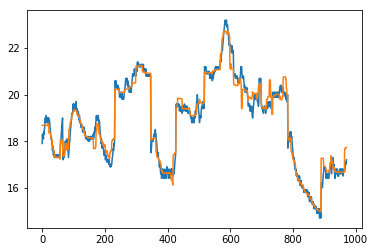

In [417]:
matplotlib.pyplot.plot(list(y_train))
matplotlib.pyplot.plot(y_k_predict.reshape(y_k_predict.shape[0]));

In [457]:
D_in = 14
D_out = 1
N = X_train.shape[0]

In [458]:
# Zufällige initialisierung der Gewichte
w = np.random.randn(D_in, D_out)

In [459]:
learning_rate = 1e-3

In [460]:
loss_hist = []
loss_hist_val = []
# Train
for t in range(100):
    # Berechne die Vorhersage
    y_pred = X_train.dot(w)
    y_pred_val = X_val.dot(w)
    y_pred = y_pred.reshape(y_pred.shape[0])
    y_pred_val = y_pred_val.reshape(y_pred_val.shape[0])
    # Berechne den Fehler (Ausgabe des Fehlers alle 100 Iterationen)
    loss = np.square(y_pred - y_train).sum()
    loss_val = np.square(y_pred_val - y_val).sum()
    if t % 2 == 0:
        loss_hist.append(loss)
        loss_hist_val.append(loss_val)
        print(t, loss)

    # Berechne die Gradienten von w1 im Bezug auf den Fehler 
    grad_y_pred = 2.0 * (y_pred - y_train)
    grad_w = (1/N) * X_train.T.dot(grad_y_pred)

    # Aktualisiere die Gewichte mittels Gradienten Abstieg
    w -= learning_rate * grad_w.sum()

0 323233.88657373795
2 235915.98945377255
4 172724.1616690615
6 126992.3331381208
8 93896.27920044112
10 69944.71589252038
12 52611.00638220905
14 40066.627481960124
16 30988.279774598283
18 24418.293508149807
20 19663.60455673207
22 16222.643478901015
24 13732.42524167693
26 11930.25813523811
28 10626.032573405224
30 9682.166541192717
32 8999.0921460608
34 8504.752257389202
36 8146.999240626435
38 7888.093932890102
40 7700.724560073622
42 7565.125633282233
44 7466.992898617074
46 7395.974389542313
48 7344.5784038051215
50 7307.38320801304
52 7280.465102052669
54 7260.984510189568
56 7246.886435834136
58 7236.683681116616
60 7229.299963227105
62 7223.956377952213
64 7220.089233511249
66 7217.290587029922
68 7215.265210877821
70 7213.799449273104
72 7212.738679855226
74 7211.97100265977
76 7211.4154358546875
78 7211.013373012733
80 7210.722400752686
82 7210.511824575826
84 7210.359430920658
86 7210.249143866909
88 7210.169329295817
90 7210.111567613532
92 7210.0697655729455
94 7210.0395

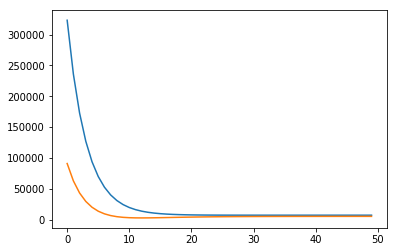

In [461]:
matplotlib.pyplot.plot(loss_hist)
matplotlib.pyplot.plot(loss_hist_val);

In [462]:
len(list(y_pred.reshape(y_pred.shape[0])))

972

In [463]:
sklearn.metrics.mean_squared_error(list(y_train), list(y_pred.reshape(y_pred.shape[0])))

7.417690926141817

In [464]:
len(list(y_train))

972

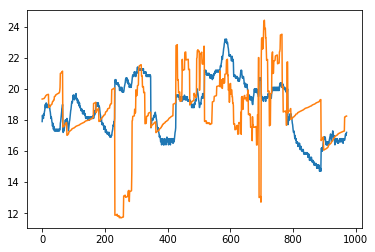

In [465]:
matplotlib.pyplot.plot(list(y_train))
matplotlib.pyplot.plot(list(y_pred));

In [466]:
#error = 
error = list(np.array(list(y_train)) - np.array(list(y_pred.reshape(y_pred.shape[0]))))

In [467]:
#matplotlib.pyplot.plot(error);

In [468]:
end_date = np.datetime64('2019-04-07 23:59:00')
start_date = np.datetime64('2019-04-07 00:00:00')

In [469]:
frame3 = frame[(frame['last_updated'] > start_date) & (frame['last_updated'] < end_date)]
frame4 = min_max_scaler.fit_transform(frame3.drop(columns=['last_updated','current_temp']))

/Users/cm/anaconda3/envs/week_program/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [470]:
frame4.shape

(93, 14)

In [471]:
knn = KNeighborsRegressor(24)
knn.fit(X_train, y_train)
y_k_predict = knn.predict(frame4)
len(y_k_predict)

93

In [472]:
len(frame4[:,1])

93

In [473]:
(y_k_predict-frame3['current_temp']).mean()

-3.4176075268817203

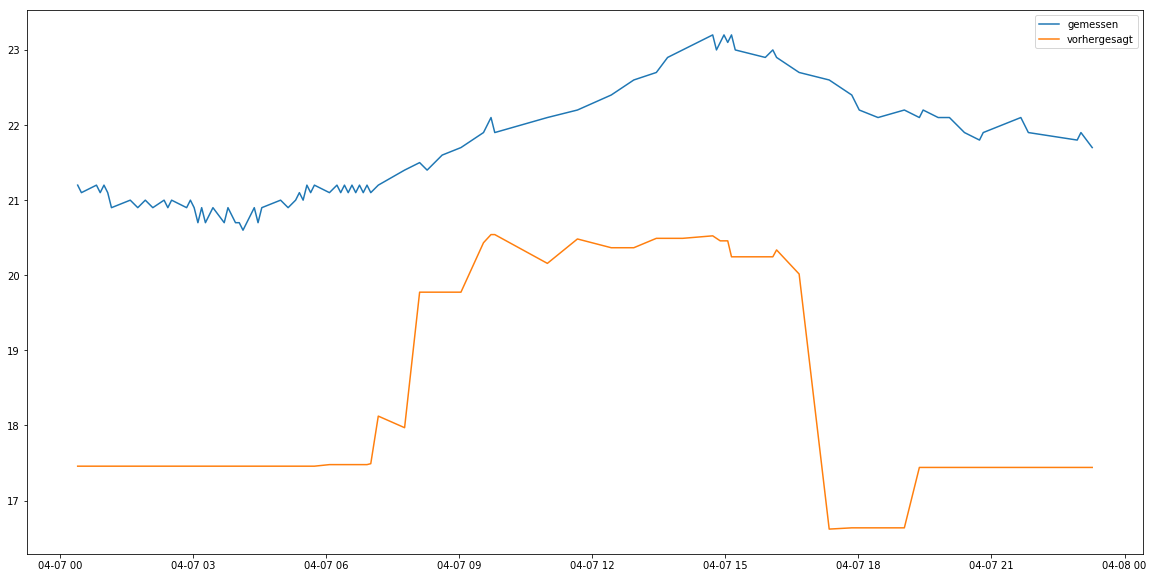

In [474]:
dates = matplotlib.dates.date2num(frame3['last_updated'])
fig1 = matplotlib.pyplot.figure(figsize=[20,10])
matplotlib.pyplot.plot_date(dates,list(frame3['current_temp']),'-')
matplotlib.pyplot.plot_date(dates,y_k_predict.reshape(y_k_predict.shape[0]),'-')
matplotlib.pyplot.legend(['gemessen','vorhergesagt']);

In [475]:
from sklearn.tree import DecisionTreeRegressor

In [476]:
# Train the model using the training sets
error = []
error_val = []
error_test = []
probilities = pd.DataFrame()
proba_test = []
proba_train = []
proba_validate = []

for i in range(1, 50):
#Predict Output
    classifier = DecisionTreeRegressor(max_depth = i)
    classifier.fit(X_train,y_train)
    y_= classifier.predict(X_train)
    y_v = classifier.predict(X_val)
    y_t = classifier.predict(X_test)
    error.append(sklearn.metrics.mean_squared_error(y_train,y_))
    error_test.append(sklearn.metrics.mean_squared_error(y_test,y_t))
    error_val.append(sklearn.metrics.mean_squared_error(y_val,y_v))

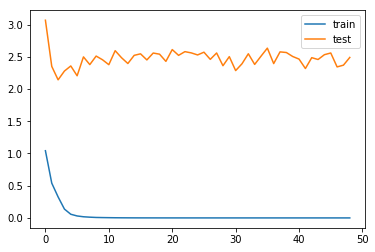

In [477]:
matplotlib.pyplot.plot(error)
#matplotlib.pyplot.plot(error_test)
matplotlib.pyplot.plot(error_val)
matplotlib.pyplot.legend(['train','test','val']);

In [478]:
dtr = DecisionTreeRegressor(max_depth=10)
dtr.fit(X_train, y_train)
y_dtr_predict = dtr.predict(frame4)

In [479]:
(y_dtr_predict-frame3['current_temp']).mean()

-0.9378494623655912

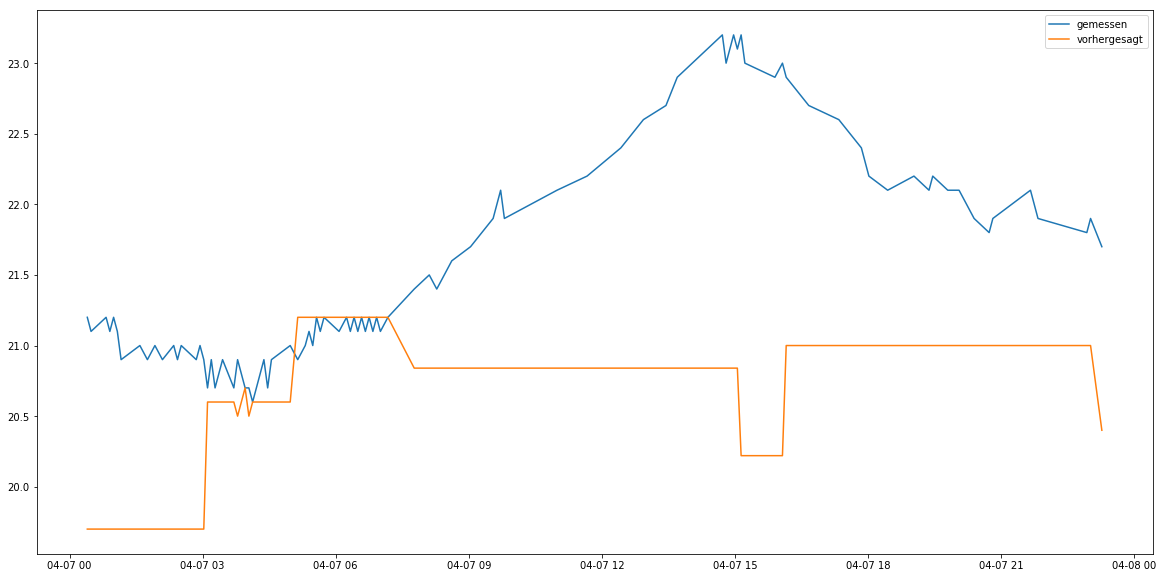

In [480]:
dates = matplotlib.dates.date2num(frame3['last_updated'])
fig1 = matplotlib.pyplot.figure(figsize=[20,10])
matplotlib.pyplot.plot_date(dates,list(frame3['current_temp']),'-')
matplotlib.pyplot.plot_date(dates,y_dtr_predict,'-')
matplotlib.pyplot.legend(['gemessen','vorhergesagt']);

In [481]:
from sklearn.ensemble import RandomForestRegressor

In [482]:
error_train = []
error_val = []

for i in range(1, 50):
    #for j in range(1,5):
        #for k in range(2,10):
    d_forest = RandomForestRegressor(n_estimators=i, n_jobs=-1, random_state=42)
    d_forest.fit(X_train, y_train)
    y_pred_train = d_forest.predict(X_train)
    y_pred_val = d_forest.predict(X_val)
    error_train.append(sklearn.metrics.mean_squared_error(y_train, y_pred_train))
    error_val.append(sklearn.metrics.mean_squared_error(y_val, y_pred_val))

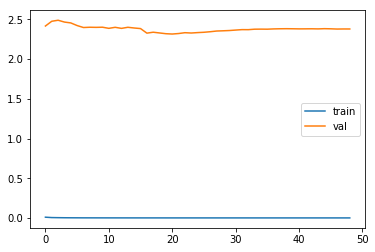

In [483]:
matplotlib.pyplot.plot(error_train)
matplotlib.pyplot.plot(error_val)
matplotlib.pyplot.legend(['train','val']);

In [484]:
fr = RandomForestRegressor(n_estimators=17, n_jobs=-1, random_state=42)
fr.fit(X_train, y_train)
y_fr_predict = fr.predict(frame4)

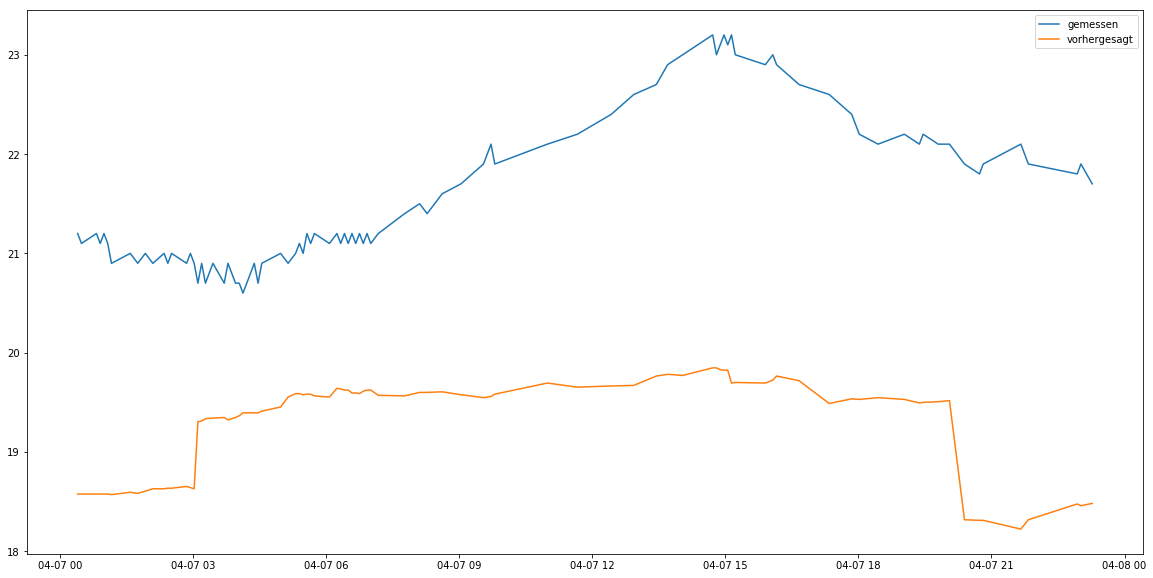

In [485]:
dates = matplotlib.dates.date2num(frame3['last_updated'])
fig1 = matplotlib.pyplot.figure(figsize=[20,10])
matplotlib.pyplot.plot_date(dates,list(frame3['current_temp']),'-')
matplotlib.pyplot.plot_date(dates,y_fr_predict,'-')
matplotlib.pyplot.legend(['gemessen','vorhergesagt']);

In [486]:
(y_fr_predict-frame3['current_temp'])#.mean()

1367   -2.623529
1368   -2.523529
1369   -2.623529
1370   -2.523529
1371   -2.623529
1372   -2.523529
1373   -2.329412
1374   -2.405882
1375   -2.317647
1376   -2.394118
1377   -2.270588
1378   -2.370588
1379   -2.264706
1380   -2.364706
1381   -2.247059
1382   -2.358824
1383   -2.270588
1384   -1.394118
1385   -1.588235
1386   -1.364706
1387   -1.558824
1388   -1.352941
1389   -1.576471
1390   -1.352941
1391   -1.335294
1392   -1.205882
1393   -1.305882
1394   -1.505882
1395   -1.305882
1396   -1.488235
          ...   
1430   -3.117647
1431   -3.229412
1432   -3.352941
1433   -3.152941
1434   -3.270588
1435   -3.376471
1436   -3.276471
1437   -3.505882
1438   -3.300000
1439   -3.205882
1440   -3.276471
1441   -3.135294
1442   -2.982353
1443   -3.111765
1444   -2.864706
1445   -2.670588
1446   -2.552941
1447   -2.670588
1448   -2.605882
1449   -2.700000
1450   -2.594118
1451   -2.582353
1452   -3.582353
1453   -3.488235
1454   -3.588235
1455   -3.876471
1456   -3.582353
1457   -3.3235

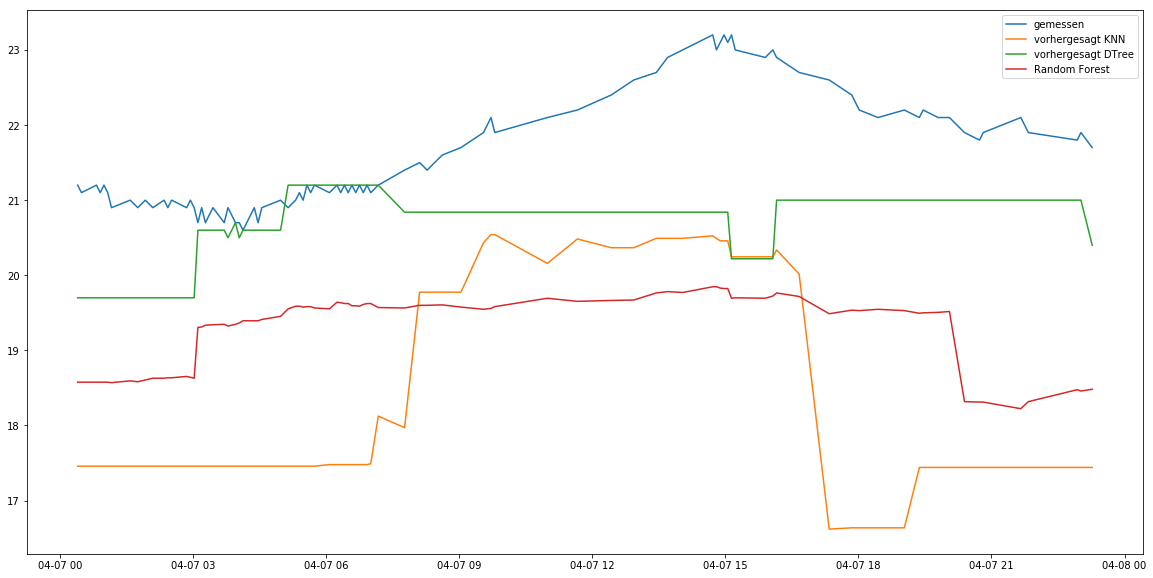

In [487]:
dates = matplotlib.dates.date2num(frame3['last_updated'])
fig1 = matplotlib.pyplot.figure(figsize=[20,10])
matplotlib.pyplot.plot_date(dates,list(frame3['current_temp']),'-')
matplotlib.pyplot.plot_date(dates,y_k_predict.reshape(y_k_predict.shape[0]),'-')
matplotlib.pyplot.plot_date(dates,y_dtr_predict,'-')
matplotlib.pyplot.plot_date(dates,y_fr_predict,'-')
matplotlib.pyplot.legend(['gemessen','vorhergesagt KNN', 'vorhergesagt DTree', 'Random Forest']);

In [489]:
torch.nn.Conv1d?